In [ ]:
import os
from glob import glob
from PIL import Image
import torch
import torchvision.transforms as transforms

IMAGE_SIZE = 64
BATCH_SIZE = 64

root_dir   = "C:/Users/hucu/Desktop/DeepLearningProject3/dataset/CatDataset/cats/Data"
exts       = ("jpg", "png", "jpeg")

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

paths = []
for e in exts:
    paths += glob(os.path.join(root_dir, f"*.{e}"))

print(f"Found {len(paths)} images in {root_dir}")

images = []
for p in paths:
    img = Image.open(p).convert("RGB")
    images.append(transform(img))

images = torch.stack(images)
print(f"Loaded images tensor with shape {images.shape}")


Found 29843 images in C:/Users/hucu/Desktop/DeepLearningProject3/dataset/CatDataset/cats/Data
Loaded images tensor with shape torch.Size([29843, 3, 64, 64])


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_bn, dropout, activation):
        super().__init__()
        layers = [nn.Conv2d(channels, channels, 3, 1, 1)]
        if use_bn: layers.append(nn.BatchNorm2d(channels))
        layers.append(nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True))
        if dropout>0: layers.append(nn.Dropout(dropout))
        layers.append(nn.Conv2d(channels, channels, 3, 1, 1))
        if use_bn: layers.append(nn.BatchNorm2d(channels))
        self.block = nn.Sequential(*layers)
        self.act   = nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)

    def forward(self, x):
        return self.act(self.block(x) + x)

def create_vae(latent_dim=128, base_channels=64,
               use_batchnorm=True, dropout_rate=0.1,
               num_res_blocks=1, activation='leaky'):
    """
    Returns a VAE model with:
      - latent_dim: dimension of z
      - base_channels: number of filters at the first conv
      - use_batchnorm: whether to apply BatchNorm2d
      - dropout_rate: dropout in residual blocks
      - num_res_blocks: number of ResidualBlock per stage
      - activation: 'leaky' or 'relu'
    """
    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            ch = base_channels
            self.down1 = nn.Sequential(
                nn.Conv2d(3, ch, 4, 2, 1),
                nn.BatchNorm2d(ch) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res1 = nn.Sequential(*[ResidualBlock(ch, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.down2 = nn.Sequential(
                nn.Conv2d(ch, ch*2, 4, 2, 1),
                nn.BatchNorm2d(ch*2) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res2 = nn.Sequential(*[ResidualBlock(ch*2, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.down3 = nn.Sequential(
                nn.Conv2d(ch*2, ch*4, 4, 2, 1),
                nn.BatchNorm2d(ch*4) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res3 = nn.Sequential(*[ResidualBlock(ch*4, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.down4 = nn.Sequential(
                nn.Conv2d(ch*4, ch*8, 4, 2, 1),
                nn.BatchNorm2d(ch*8) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res4 = nn.Sequential(*[ResidualBlock(ch*8, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.fc_mu     = nn.Linear(ch*8*4*4, latent_dim)
            self.fc_logvar = nn.Linear(ch*8*4*4, latent_dim)

        def forward(self, x):
            x = self.down1(x); x = self.res1(x)
            x = self.down2(x); x = self.res2(x)
            x = self.down3(x); x = self.res3(x)
            x = self.down4(x); x = self.res4(x)
            x = x.view(x.size(0), -1)
            return self.fc_mu(x), self.fc_logvar(x)

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            ch = base_channels
            self.fc = nn.Linear(latent_dim, ch*8*4*4)
            self.up1 = nn.Sequential(
                nn.ConvTranspose2d(ch*8, ch*4, 4, 2, 1),
                nn.BatchNorm2d(ch*4) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res1 = nn.Sequential(*[ResidualBlock(ch*4, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.up2 = nn.Sequential(
                nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1),
                nn.BatchNorm2d(ch*2) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res2 = nn.Sequential(*[ResidualBlock(ch*2, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.up3 = nn.Sequential(
                nn.ConvTranspose2d(ch*2, ch, 4, 2, 1),
                nn.BatchNorm2d(ch) if use_batchnorm else nn.Identity(),
                nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
            )
            self.res3 = nn.Sequential(*[ResidualBlock(ch, use_batchnorm, dropout_rate, activation)
                                        for _ in range(num_res_blocks)])
            self.up4 = nn.ConvTranspose2d(ch, 3, 4, 2, 1)
            self.act_out = nn.Tanh()

        def forward(self, z):
            x = self.fc(z).view(z.size(0), base_channels*8, 4, 4)
            x = self.up1(x); x = self.res1(x)
            x = self.up2(x); x = self.res2(x)
            x = self.up3(x); x = self.res3(x)
            return self.act_out(self.up4(x))

    class VAEModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = Encoder()
            self.decoder = Decoder()

        def reparameterize(self, mu, logvar):
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            return mu + eps * std

        def forward(self, x):
            mu, logvar = self.encoder(x)
            z = self.reparameterize(mu, logvar)
            recon = self.decoder(z)
            return recon, mu, logvar

    return VAEModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_vae(
    latent_dim=256,
    base_channels=64,
    use_batchnorm=True,
    dropout_rate=0.1,
    num_res_blocks=2,
    activation='leaky'
).to(device)

In [ ]:

import optuna
import torch
import torch.nn.functional as F
from torch.optim import Adam, RMSprop, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler
from tqdm import tqdm
from torchvision.utils import save_image
from torcheval.metrics import FrechetInceptionDistance

loss_history = []
fid_history = []
fid_epochs = []
fid_metric = FrechetInceptionDistance()

N = images.size(0)

def objective(trial):
    arch_params = {
        "latent_dim": trial.suggest_int("latent_dim", 64, 256, step=64),
        "base_channels": trial.suggest_categorical("base_channels", [32, 64, 128]),
        "use_batchnorm": trial.suggest_categorical("use_batchnorm", [True, False]),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.0, 0.3),
        "num_res_blocks": trial.suggest_int("num_res_blocks", 0, 2),
        "activation": trial.suggest_categorical("activation", ["leaky", "relu"])
    }
    optim_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    beta1       = trial.suggest_float("beta1", 0.5, 0.9)
    beta2       = trial.suggest_float("beta2", 0.9, 0.999)
    weight_decay= trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    model_t = create_vae(**arch_params).to(device)
    if optim_name=="Adam":
        optim_t = Adam(model_t.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
    elif optim_name=="RMSprop":
        optim_t = RMSprop(model_t.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optim_t = AdamW(model_t.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
    scaler_t = GradScaler()

    for _ in range(5):
        model_t.train()
        perm = torch.randperm(N)
        for i in range(0, N, BATCH_SIZE):
            batch = images[perm[i:i+BATCH_SIZE]].to(device, non_blocking=True)
            optim_t.zero_grad()
            with torch.amp.autocast('cuda'):
                recon, mu, logvar = model_t(batch)
                recon_l = F.mse_loss(recon, batch, reduction="sum")
                kl_l    = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss    = (recon_l + kl_l) / batch.size(0)
            scaler_t.scale(loss).backward()
            scaler_t.step(optim_t)
            scaler_t.update()

    model_t.eval()
    total = 0.0
    with torch.no_grad():
        perm = torch.randperm(N)
        for i in range(0, N, BATCH_SIZE):
            batch = images[perm[i:i+BATCH_SIZE]].to(device)
            recon, mu, logvar = model_t(batch)
            rl = F.mse_loss(recon, batch, reduction="sum")
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            total += (rl + kl).item()
    return total / N

# Run Optuna to find best hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best = study.best_trial.params
print("Best hyperparameters:", best)

# Final training with best params
EPOCHS_FULL = 50
arch_params = {k: best[k] for k in ["latent_dim","base_channels",
                                    "use_batchnorm","dropout_rate",
                                    "num_res_blocks","activation"]}
model = create_vae(**arch_params).to(device)

optim_type = best["optimizer"]
lr, b1, b2 = best["lr"], best["beta1"], best["beta2"]
wd = best["weight_decay"]
if optim_type=="Adam":
    optimizer = Adam(model.parameters(), lr=lr, betas=(b1,b2), weight_decay=wd)
elif optim_type=="RMSprop":
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=wd)
else:
    optimizer = AdamW(model.parameters(), lr=lr, betas=(b1,b2), weight_decay=wd)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_FULL, eta_min=1e-5)
scaler    = GradScaler('cuda')


#create new folder to save all generated images
import datetime, os
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = f"./vae_full_run_{ts}"
os.makedirs(run_dir, exist_ok=True)

for epoch in range(1, EPOCHS_FULL+1):
    model.train()
    perm = torch.randperm(N)
    ep_loss = 0.0
    for i in range(0, N, BATCH_SIZE):
        batch = images[perm[i:i+BATCH_SIZE]].to(device, non_blocking=True)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            recon, mu, logvar = model(batch)
            rl = F.mse_loss(recon, batch, reduction="sum")
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = (rl + kl) / batch.size(0)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ep_loss += loss.item() * batch.size(0)
    scheduler.step()
    avg = ep_loss / N
    loss_history.append(avg)

    model.eval()
    with torch.no_grad():
        z = torch.randn(16, best["latent_dim"], device=device)
        samples = model.decoder(z).mul(0.5).add(0.5)
        save_image(samples, f"{run_dir}/epoch_{epoch:02d}.png", nrow=4)

    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(100, best["latent_dim"], device=device)
            fake = model.decoder(z).mul(0.5).add(0.5)
            real_idx = torch.randperm(N)[:100]
            real = images[real_idx].to(device).mul(0.5).add(0.5)
        fid_metric.reset()
        fid_metric.update(fake, is_real=False)
        fid_metric.update(real, is_real=True)
        fid_val = fid_metric.compute().item()
        fid_history.append(fid_val)
        fid_epochs.append(epoch)
        print(f"Epoch {epoch}/{EPOCHS_FULL} – Loss: {avg:.4f} – FID@{epoch}: {fid_val:.2f}")
    else:
        print(f"Epoch {epoch}/{EPOCHS_FULL} – Loss: {avg:.4f}")


[I 2025-05-26 15:49:25,873] A new study created in memory with name: no-name-023dcf8d-1a84-47e1-ad10-f85915c65ccc
[W 2025-05-26 15:53:20,966] Trial 0 failed with parameters: {'latent_dim': 64, 'base_channels': 128, 'use_batchnorm': True, 'dropout_rate': 0.06335761675240704, 'num_res_blocks': 2, 'activation': 'leaky', 'optimizer': 'RMSprop', 'lr': 0.0002505409335895826, 'beta1': 0.898475877718499, 'beta2': 0.9376494015127174, 'weight_decay': 2.4568926688233307e-06} because of the following error: The value nan is not acceptable.
[W 2025-05-26 15:53:20,967] Trial 0 failed with value nan.
[I 2025-05-26 15:54:17,196] Trial 1 finished with value: 572.3192440830974 and parameters: {'latent_dim': 256, 'base_channels': 64, 'use_batchnorm': False, 'dropout_rate': 0.2584305132074578, 'num_res_blocks': 1, 'activation': 'relu', 'optimizer': 'Adam', 'lr': 0.0014929642956295886, 'beta1': 0.8324112328565167, 'beta2': 0.9054686950748492, 'weight_decay': 4.003497530738137e-06}. Best is trial 1 with val

Best hyperparameters: {'latent_dim': 64, 'base_channels': 128, 'use_batchnorm': True, 'dropout_rate': 0.031160141954999353, 'num_res_blocks': 0, 'activation': 'relu', 'optimizer': 'Adam', 'lr': 0.0001242082199236914, 'beta1': 0.6673334995241943, 'beta2': 0.9768002168271448, 'weight_decay': 0.00045911989171785653}
Epoch 1/50 – Loss: 44896.0387
Epoch 2/50 – Loss: 697.0804
Epoch 3/50 – Loss: 635.5153
Epoch 4/50 – Loss: 609.1312
Epoch 5/50 – Loss: 587.8229
Epoch 6/50 – Loss: 572.0019
Epoch 7/50 – Loss: 558.8588
Epoch 8/50 – Loss: 550.3659
Epoch 9/50 – Loss: 540.5100
Epoch 10/50 – Loss: 530.7609 – FID@10: 274.78
Epoch 11/50 – Loss: 522.5755
Epoch 12/50 – Loss: 516.3821
Epoch 13/50 – Loss: 509.6458
Epoch 14/50 – Loss: 500.9979
Epoch 15/50 – Loss: 494.8669
Epoch 16/50 – Loss: 490.0753
Epoch 17/50 – Loss: 483.5553
Epoch 18/50 – Loss: 479.9415
Epoch 19/50 – Loss: 474.4275
Epoch 20/50 – Loss: 470.0147 – FID@20: 255.45
Epoch 21/50 – Loss: 466.6866
Epoch 22/50 – Loss: 461.6827
Epoch 23/50 – Loss: 

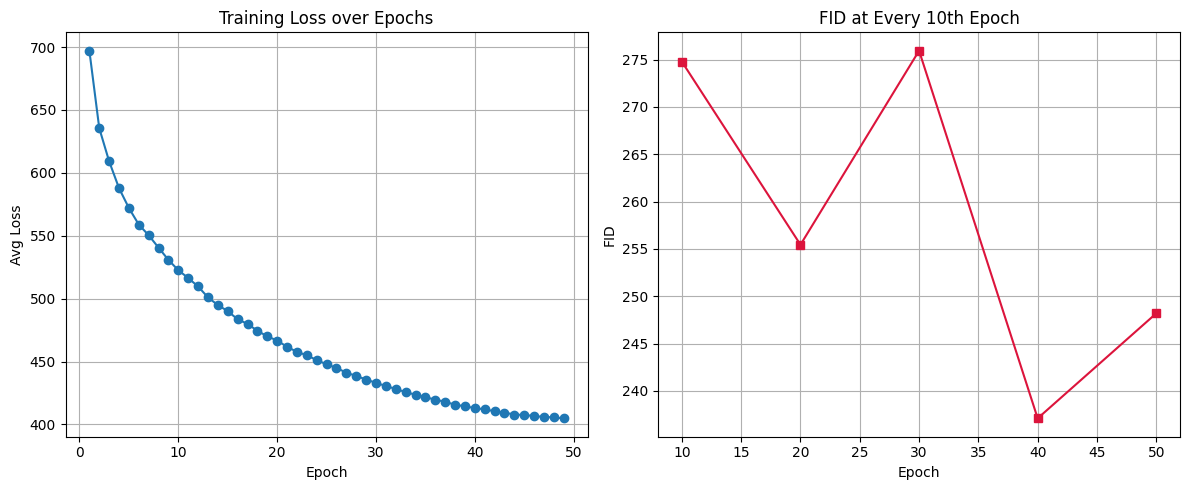

Final Loss: 404.8301
Final recorded FID (epoch 50): 248.20


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS_FULL), loss_history[1:], marker='o') #disregard first epoch due to very high loss
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fid_epochs, fid_history, marker='s', color='crimson')
plt.title("FID at Every 10th Epoch")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Loss: {loss_history[-1]:.4f}")
print(f"Final recorded FID (epoch {fid_epochs[-1]}): {fid_history[-1]:.2f}")

In [ ]:
import torch
from torchvision.utils import save_image


latent_dim = arch_params['latent_dim']
model.eval()
with torch.no_grad():
    z0 = torch.randn(1, latent_dim, device=device)
    z1 = torch.randn(1, latent_dim, device=device)
    x0 = model.decoder(z0).mul(0.5).add(0.5)
    x1 = model.decoder(z1).mul(0.5).add(0.5)

    save_image(x0, "vae_endpoint0.png")
    save_image(x1, "vae_endpoint1.png")

    alphas = torch.linspace(0, 1, steps=10, device=device).unsqueeze(1)
    z_interp = (1 - alphas) * z0 + alphas * z1
    x_interp = model.decoder(z_interp).mul(0.5).add(0.5)

    save_image(x_interp, "vae_interpolation.png", nrow=5)

In [28]:
with torch.no_grad():
    B = 16
    z_rand = torch.randn(B, latent_dim, device=device)
    x_rand = model.decoder(z_rand).mul(0.5).add(0.5)
    save_image(x_rand, "vae_random_samples.png", nrow=4)